In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

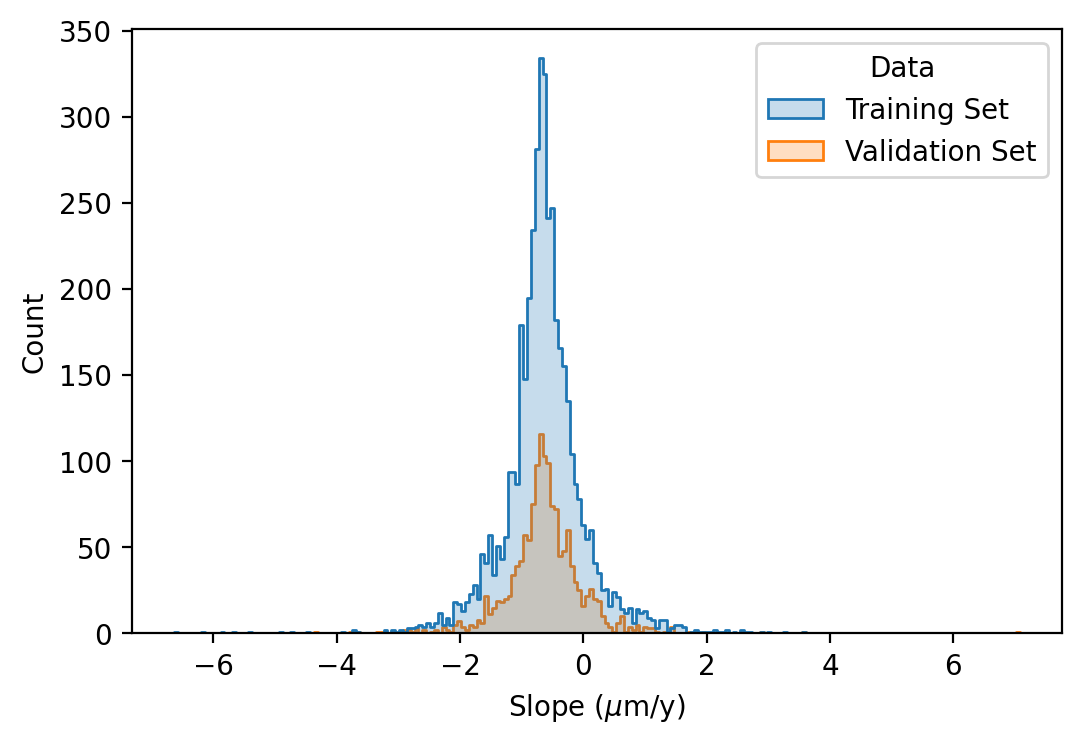

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_cnn_ts3_2.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:09<00:00,  7.55it/s, batch_loss=0.61, running_loss=32.5]


Train Loss: 32.4879 | Valid Loss: inf ===========> 10.2127 | Test Loss: 11.5394 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:09<00:00,  7.41it/s, batch_loss=0.477, running_loss=31.2]


Train Loss: 31.2350 | Valid Loss: 10.3161


Epoch [3/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.201, running_loss=30.2]


Train Loss: 30.2085 | Valid Loss: 10.2127 ===========> 9.9199 | Test Loss: 10.8343 | Saving model...


Epoch [4/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.546, running_loss=29.1]


Train Loss: 29.0530 | Valid Loss: 9.9199 ===========> 9.5725 | Test Loss: 10.1010 | Saving model...


Epoch [5/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.21, running_loss=28]


Train Loss: 28.0343 | Valid Loss: 9.5725 ===========> 9.5475 | Test Loss: 9.9199 | Saving model...


Epoch [6/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.329, running_loss=26.6]


Train Loss: 26.5819 | Valid Loss: 9.5475 ===========> 8.9465 | Test Loss: 8.9099 | Saving model...


Epoch [7/200]: 100%|██████████| 70/70 [00:08<00:00,  7.84it/s, batch_loss=0.391, running_loss=25.2]


Train Loss: 25.2250 | Valid Loss: 8.9465 ===========> 8.1416 | Test Loss: 8.8512 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:08<00:00,  7.87it/s, batch_loss=0.381, running_loss=22.8]


Train Loss: 22.8300 | Valid Loss: 8.1416 ===========> 8.0661 | Test Loss: 8.8411 | Saving model...


Epoch [9/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.202, running_loss=20.7]


Train Loss: 20.6650 | Valid Loss: 8.0661 ===========> 7.5843 | Test Loss: 8.2720 | Saving model...


Epoch [10/200]: 100%|██████████| 70/70 [00:08<00:00,  7.85it/s, batch_loss=0.184, running_loss=20.2]


Train Loss: 20.1562 | Valid Loss: 7.5843 ===========> 7.3498 | Test Loss: 8.2168 | Saving model...


Epoch [11/200]: 100%|██████████| 70/70 [00:08<00:00,  7.86it/s, batch_loss=0.163, running_loss=18.2]


Train Loss: 18.2462 | Valid Loss: 7.5429


Epoch [12/200]: 100%|██████████| 70/70 [00:08<00:00,  7.79it/s, batch_loss=0.706, running_loss=17.6]


Train Loss: 17.6010 | Valid Loss: 12.4425


Epoch [13/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.175, running_loss=16]


Train Loss: 16.0357 | Valid Loss: 7.3498 ===========> 7.1348 | Test Loss: 7.5044 | Saving model...


Epoch [14/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.15, running_loss=15.1]


Train Loss: 15.0847 | Valid Loss: 7.2077


Epoch [15/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.175, running_loss=14.1]


Train Loss: 14.0643 | Valid Loss: 7.1348 ===========> 6.7320 | Test Loss: 7.1172 | Saving model...


Epoch [16/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.133, running_loss=13.1]


Train Loss: 13.0543 | Valid Loss: 7.2087


Epoch [17/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0921, running_loss=12.5]


Train Loss: 12.5461 | Valid Loss: 7.3858


Epoch [18/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.114, running_loss=11.7]


Train Loss: 11.6750 | Valid Loss: 6.7320 ===========> 6.5302 | Test Loss: 6.7878 | Saving model...


Epoch [19/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.158, running_loss=11.1]


Train Loss: 11.1112 | Valid Loss: 6.5302 ===========> 6.0643 | Test Loss: 6.6862 | Saving model...


Epoch [20/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.113, running_loss=11.1]


Train Loss: 11.0831 | Valid Loss: 8.0860


Epoch [21/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0801, running_loss=10]


Train Loss: 10.0293 | Valid Loss: 6.0643 ===========> 5.9800 | Test Loss: 6.6653 | Saving model...


Epoch [22/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.211, running_loss=9.65]


Train Loss: 9.6523 | Valid Loss: 6.4426


Epoch [23/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0973, running_loss=9.05]


Train Loss: 9.0540 | Valid Loss: 6.2340


Epoch [24/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.075, running_loss=8.47]


Train Loss: 8.4687 | Valid Loss: 6.1670


Epoch [25/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.11, running_loss=7.67]


Train Loss: 7.6698 | Valid Loss: 6.0378


Epoch [26/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0645, running_loss=7.37]


Train Loss: 7.3659 | Valid Loss: 6.9422


Epoch [27/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0984, running_loss=7.04]


Train Loss: 7.0367 | Valid Loss: 6.3080


Epoch [28/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0759, running_loss=6.56]


Train Loss: 6.5609 | Valid Loss: 6.3637


Epoch [29/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.24, running_loss=6.46]


Train Loss: 6.4574 | Valid Loss: 6.8511


Epoch [30/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0666, running_loss=5.74]


Train Loss: 5.7429 | Valid Loss: 6.0085


Epoch [31/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0683, running_loss=5.9]


Train Loss: 5.9015 | Valid Loss: 6.3645


Epoch [32/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0651, running_loss=5.43]


Train Loss: 5.4287 | Valid Loss: 6.6792


Epoch [33/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.111, running_loss=4.97]


Train Loss: 4.9650 | Valid Loss: 7.4195


Epoch [34/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0309, running_loss=4.52]


Train Loss: 4.5192 | Valid Loss: 6.3462


Epoch [35/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0877, running_loss=4.55]


Train Loss: 4.5548 | Valid Loss: 6.7998


Epoch [36/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0558, running_loss=4.47]


Train Loss: 4.4704 | Valid Loss: 6.1293


Epoch [37/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0635, running_loss=4.11]


Train Loss: 4.1141 | Valid Loss: 6.2522


Epoch [38/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0661, running_loss=4.24]


Train Loss: 4.2387 | Valid Loss: 6.1693


Epoch [39/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0905, running_loss=3.96]


Train Loss: 3.9583 | Valid Loss: 6.4393


Epoch [40/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0447, running_loss=4.02]


Train Loss: 4.0176 | Valid Loss: 5.9800 ===========> 5.9128 | Test Loss: 6.5154 | Saving model...


Epoch [41/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0444, running_loss=3.79]


Train Loss: 3.7893 | Valid Loss: 6.3082


Epoch [42/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0342, running_loss=3.62]


Train Loss: 3.6191 | Valid Loss: 7.0697


Epoch [43/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0839, running_loss=3.42]


Train Loss: 3.4166 | Valid Loss: 5.9128 ===========> 5.9117 | Test Loss: 6.1078 | Saving model...


Epoch [44/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0514, running_loss=3.34]


Train Loss: 3.3446 | Valid Loss: 6.3934


Epoch [45/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0523, running_loss=3.2]


Train Loss: 3.2006 | Valid Loss: 6.6281


Epoch [46/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0327, running_loss=3.14]


Train Loss: 3.1387 | Valid Loss: 6.2310


Epoch [47/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0384, running_loss=2.89]


Train Loss: 2.8882 | Valid Loss: 6.9049


Epoch [48/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0493, running_loss=2.78]


Train Loss: 2.7760 | Valid Loss: 9.2525


Epoch [49/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0433, running_loss=2.65]


Train Loss: 2.6508 | Valid Loss: 6.1510


Epoch [50/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0367, running_loss=2.83]


Train Loss: 2.8277 | Valid Loss: 5.9117 ===========> 5.8113 | Test Loss: 6.1275 | Saving model...


Epoch [51/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0441, running_loss=2.73]


Train Loss: 2.7254 | Valid Loss: 5.9786


Epoch [52/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0233, running_loss=2.72]


Train Loss: 2.7169 | Valid Loss: 6.6956


Epoch [53/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0423, running_loss=2.54]


Train Loss: 2.5385 | Valid Loss: 5.8113 ===========> 5.7716 | Test Loss: 6.2091 | Saving model...


Epoch [54/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0116, running_loss=2.63]


Train Loss: 2.6305 | Valid Loss: 6.0220


Epoch [55/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.047, running_loss=2.46]


Train Loss: 2.4610 | Valid Loss: 6.1949


Epoch [56/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.157, running_loss=2.64]


Train Loss: 2.6381 | Valid Loss: 6.3030


Epoch [57/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0658, running_loss=2.57]


Train Loss: 2.5735 | Valid Loss: 6.5930


Epoch [58/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0396, running_loss=2.58]


Train Loss: 2.5837 | Valid Loss: 6.4938


Epoch [59/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0211, running_loss=2.37]


Train Loss: 2.3677 | Valid Loss: 6.1427


Epoch [60/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0153, running_loss=2.31]


Train Loss: 2.3101 | Valid Loss: 6.1163


Epoch [61/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0436, running_loss=2.3]


Train Loss: 2.2950 | Valid Loss: 6.0728


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0273, running_loss=2.18]


Train Loss: 2.1846 | Valid Loss: 5.9298


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0335, running_loss=2.21]


Train Loss: 2.2061 | Valid Loss: 6.2979


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0699, running_loss=2.16]


Train Loss: 2.1604 | Valid Loss: 6.4063


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.061, running_loss=2.28]


Train Loss: 2.2813 | Valid Loss: 6.9849


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0468, running_loss=2.17]


Train Loss: 2.1749 | Valid Loss: 6.5202


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0265, running_loss=2.03]


Train Loss: 2.0318 | Valid Loss: 6.0594


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.012, running_loss=1.98]


Train Loss: 1.9847 | Valid Loss: 5.9067


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0355, running_loss=1.99]


Train Loss: 1.9888 | Valid Loss: 6.1199


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0208, running_loss=2.07]


Train Loss: 2.0657 | Valid Loss: 6.0099


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0492, running_loss=2.01]


Train Loss: 2.0105 | Valid Loss: 6.4082


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0141, running_loss=2]


Train Loss: 2.0010 | Valid Loss: 5.9704


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0322, running_loss=1.9]


Train Loss: 1.9034 | Valid Loss: 6.1508


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0197, running_loss=1.88]


Train Loss: 1.8825 | Valid Loss: 6.1157


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0273, running_loss=1.88]


Train Loss: 1.8755 | Valid Loss: 6.3797


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0338, running_loss=1.9]


Train Loss: 1.8964 | Valid Loss: 5.9138


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0225, running_loss=1.9]


Train Loss: 1.9033 | Valid Loss: 5.8756


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0487, running_loss=1.85]


Train Loss: 1.8550 | Valid Loss: 6.2404


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.026, running_loss=1.94]


Train Loss: 1.9360 | Valid Loss: 6.0472


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0273, running_loss=1.86]


Train Loss: 1.8646 | Valid Loss: 5.8757


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0249, running_loss=1.79]


Train Loss: 1.7916 | Valid Loss: 6.1063


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0193, running_loss=1.77]


Train Loss: 1.7660 | Valid Loss: 5.9876


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.01, running_loss=1.78]


Train Loss: 1.7759 | Valid Loss: 6.4466


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0171, running_loss=1.78]


Train Loss: 1.7754 | Valid Loss: 5.9028


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0288, running_loss=1.75]


Train Loss: 1.7500 | Valid Loss: 6.2632


Epoch [86/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0251, running_loss=1.75]


Train Loss: 1.7476 | Valid Loss: 5.9557


Epoch [87/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0198, running_loss=1.74]


Train Loss: 1.7376 | Valid Loss: 6.1344


Epoch [88/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.053, running_loss=1.67]


Train Loss: 1.6702 | Valid Loss: 7.7696


Epoch [89/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.022, running_loss=1.75]


Train Loss: 1.7518 | Valid Loss: 6.3055


Epoch [90/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0118, running_loss=1.67]


Train Loss: 1.6704 | Valid Loss: 5.9660


Epoch [91/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0605, running_loss=1.73]


Train Loss: 1.7336 | Valid Loss: 6.6076


Epoch [92/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0211, running_loss=1.71]


Train Loss: 1.7093 | Valid Loss: 6.0709


Epoch [93/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0169, running_loss=1.65]


Train Loss: 1.6457 | Valid Loss: 6.6034


Epoch [94/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0744, running_loss=1.67]


Train Loss: 1.6669 | Valid Loss: 6.1233


Epoch [95/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0299, running_loss=1.74]


Train Loss: 1.7378 | Valid Loss: 6.0035


Epoch [96/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.019, running_loss=1.69]


Train Loss: 1.6931 | Valid Loss: 5.9828


Epoch [97/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.064, running_loss=1.68]


Train Loss: 1.6848 | Valid Loss: 6.2672


Epoch [98/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0242, running_loss=1.62]


Train Loss: 1.6181 | Valid Loss: 5.8907


Epoch [99/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0162, running_loss=1.65]


Train Loss: 1.6496 | Valid Loss: 6.0087


Epoch [100/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0307, running_loss=1.55]


Train Loss: 1.5477 | Valid Loss: 6.8382


Epoch [101/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0172, running_loss=1.58]


Train Loss: 1.5827 | Valid Loss: 6.0646


Epoch [102/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0196, running_loss=1.62]


Train Loss: 1.6223 | Valid Loss: 5.9691


Epoch [103/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0161, running_loss=1.6]


Train Loss: 1.5996 | Valid Loss: 5.9768


Epoch [104/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0131, running_loss=1.59]


Train Loss: 1.5911 | Valid Loss: 6.1881


Epoch [105/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0401, running_loss=1.61]


Train Loss: 1.6080 | Valid Loss: 6.0415


Epoch [106/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.102, running_loss=1.67]


Train Loss: 1.6697 | Valid Loss: 6.2557


Epoch [107/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0217, running_loss=1.55]


Train Loss: 1.5542 | Valid Loss: 6.3397


Epoch [108/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0146, running_loss=1.53]


Train Loss: 1.5287 | Valid Loss: 6.0904


Epoch [109/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0226, running_loss=1.52]


Train Loss: 1.5228 | Valid Loss: 6.0594


Epoch [110/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.0122, running_loss=1.53]


Train Loss: 1.5271 | Valid Loss: 6.0442


Epoch [111/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00762, running_loss=1.54]


Train Loss: 1.5393 | Valid Loss: 5.8729


Epoch [112/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0174, running_loss=1.5]


Train Loss: 1.5038 | Valid Loss: 5.8433


Epoch [113/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0237, running_loss=1.49]


Train Loss: 1.4885 | Valid Loss: 9.1088


Epoch [114/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0356, running_loss=1.48]


Train Loss: 1.4809 | Valid Loss: 6.0376


Epoch [115/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.015, running_loss=1.54]


Train Loss: 1.5412 | Valid Loss: 5.7716 ===========> 5.7413 | Test Loss: 6.4071 | Saving model...


Epoch [116/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0396, running_loss=1.49]


Train Loss: 1.4890 | Valid Loss: 6.5691


Epoch [117/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0724, running_loss=1.49]


Train Loss: 1.4937 | Valid Loss: 5.8956


Epoch [118/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0136, running_loss=1.51]


Train Loss: 1.5090 | Valid Loss: 6.1087


Epoch [119/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0279, running_loss=1.45]


Train Loss: 1.4485 | Valid Loss: 6.5699


Epoch [120/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0146, running_loss=1.48]


Train Loss: 1.4820 | Valid Loss: 5.9868


Epoch [121/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00701, running_loss=1.3]


Train Loss: 1.3028 | Valid Loss: 5.9775


Epoch [122/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0166, running_loss=1.33]


Train Loss: 1.3305 | Valid Loss: 5.9963


Epoch [123/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0193, running_loss=1.33]


Train Loss: 1.3277 | Valid Loss: 6.2839


Epoch [124/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00612, running_loss=1.29]


Train Loss: 1.2929 | Valid Loss: 5.9378


Epoch [125/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0535, running_loss=1.29]


Train Loss: 1.2901 | Valid Loss: 6.0701


Epoch [126/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.00917, running_loss=1.27]


Train Loss: 1.2690 | Valid Loss: 6.0046


Epoch [127/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00809, running_loss=1.27]


Train Loss: 1.2681 | Valid Loss: 5.9360


Epoch [128/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0135, running_loss=1.26]


Train Loss: 1.2606 | Valid Loss: 6.0494


Epoch [129/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0145, running_loss=1.3]


Train Loss: 1.3001 | Valid Loss: 6.0103


Epoch [130/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0299, running_loss=1.32]


Train Loss: 1.3151 | Valid Loss: 6.1061


Epoch [131/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.00957, running_loss=1.27]


Train Loss: 1.2650 | Valid Loss: 7.0032


Epoch [132/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0153, running_loss=1.22]


Train Loss: 1.2208 | Valid Loss: 6.1074


Epoch [133/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0457, running_loss=1.31]


Train Loss: 1.3065 | Valid Loss: 6.4133


Epoch [134/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00926, running_loss=1.23]


Train Loss: 1.2333 | Valid Loss: 5.9692


Epoch [135/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0397, running_loss=1.25]


Train Loss: 1.2501 | Valid Loss: 5.9731


Epoch [136/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0114, running_loss=1.28]


Train Loss: 1.2762 | Valid Loss: 6.0757


Epoch [137/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.012, running_loss=1.26]


Train Loss: 1.2579 | Valid Loss: 5.9442


Epoch [138/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0118, running_loss=1.22]


Train Loss: 1.2243 | Valid Loss: 5.9173


Epoch [139/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0101, running_loss=1.27]


Train Loss: 1.2675 | Valid Loss: 6.0733


Epoch [140/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0118, running_loss=1.21]


Train Loss: 1.2111 | Valid Loss: 5.9487


Epoch [141/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0232, running_loss=1.25]


Train Loss: 1.2490 | Valid Loss: 6.0206


Epoch [142/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0168, running_loss=1.28]


Train Loss: 1.2786 | Valid Loss: 5.9843


Epoch [143/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0142, running_loss=1.28]


Train Loss: 1.2756 | Valid Loss: 5.9597


Epoch [144/200]: 100%|██████████| 70/70 [00:09<00:00,  7.72it/s, batch_loss=0.034, running_loss=1.23]


Train Loss: 1.2255 | Valid Loss: 5.9768


Epoch [145/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.012, running_loss=1.21]


Train Loss: 1.2110 | Valid Loss: 5.9329


Epoch [146/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0126, running_loss=1.21]


Train Loss: 1.2084 | Valid Loss: 5.9727


Epoch [147/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.013, running_loss=1.27]


Train Loss: 1.2739 | Valid Loss: 5.9464


Epoch [148/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0197, running_loss=1.25]


Train Loss: 1.2457 | Valid Loss: 5.9495


Epoch [149/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0287, running_loss=1.23]


Train Loss: 1.2318 | Valid Loss: 6.1725


Epoch [150/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.017, running_loss=1.21]


Train Loss: 1.2071 | Valid Loss: 5.9679


Epoch [151/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0168, running_loss=1.26]


Train Loss: 1.2617 | Valid Loss: 6.0653


Epoch [152/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0155, running_loss=1.2]


Train Loss: 1.1989 | Valid Loss: 6.0237


Epoch [153/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0247, running_loss=1.23]


Train Loss: 1.2289 | Valid Loss: 5.9421


Epoch [154/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0262, running_loss=1.2]


Train Loss: 1.1957 | Valid Loss: 6.0180


Epoch [155/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0283, running_loss=1.25]


Train Loss: 1.2531 | Valid Loss: 5.9043


Epoch [156/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0147, running_loss=1.23]


Train Loss: 1.2338 | Valid Loss: 5.9731


Epoch [157/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.012, running_loss=1.21]


Train Loss: 1.2149 | Valid Loss: 6.1039


Epoch [158/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0169, running_loss=1.26]


Train Loss: 1.2590 | Valid Loss: 6.0485


Epoch [159/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0172, running_loss=1.23]


Train Loss: 1.2293 | Valid Loss: 5.9119


Epoch [160/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0223, running_loss=1.22]


Train Loss: 1.2241 | Valid Loss: 5.9974


Epoch [161/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0104, running_loss=1.26]


Train Loss: 1.2553 | Valid Loss: 6.5884


Epoch [162/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.00926, running_loss=1.2]


Train Loss: 1.1998 | Valid Loss: 6.2633


Epoch [163/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0274, running_loss=1.18]


Train Loss: 1.1792 | Valid Loss: 5.9623


Epoch [164/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0107, running_loss=1.22]


Train Loss: 1.2226 | Valid Loss: 9.2787


Epoch [165/200]: 100%|██████████| 70/70 [00:09<00:00,  7.73it/s, batch_loss=0.00528, running_loss=1.19]


Train Loss: 1.1930 | Valid Loss: 5.9899


Epoch [166/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00986, running_loss=1.25]


Train Loss: 1.2536 | Valid Loss: 6.3479


Epoch [167/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.022, running_loss=1.2]


Train Loss: 1.1998 | Valid Loss: 6.0463


Epoch [168/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0436, running_loss=1.25]


Train Loss: 1.2517 | Valid Loss: 6.0127


Epoch [169/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0239, running_loss=1.24]


Train Loss: 1.2370 | Valid Loss: 6.0068


Epoch [170/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0264, running_loss=1.23]


Train Loss: 1.2340 | Valid Loss: 5.9627


Epoch [171/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0155, running_loss=1.19]


Train Loss: 1.1949 | Valid Loss: 5.9328


Epoch [172/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0122, running_loss=1.22]


Train Loss: 1.2227 | Valid Loss: 6.0544


Epoch [173/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0143, running_loss=1.24]


Train Loss: 1.2353 | Valid Loss: 5.9699


Epoch [174/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0518, running_loss=1.2]


Train Loss: 1.2047 | Valid Loss: 5.9509


Epoch [175/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0227, running_loss=1.24]


Train Loss: 1.2446 | Valid Loss: 6.0851


Epoch [176/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.03, running_loss=1.23]


Train Loss: 1.2252 | Valid Loss: 5.8974


Epoch [177/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0177, running_loss=1.18]


Train Loss: 1.1821 | Valid Loss: 7.8918


Epoch [178/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0295, running_loss=1.22]


Train Loss: 1.2159 | Valid Loss: 6.0590


Epoch [179/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.0144, running_loss=1.21]


Train Loss: 1.2136 | Valid Loss: 6.0543


Epoch [180/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0095, running_loss=1.18]


Train Loss: 1.1829 | Valid Loss: 6.0187


Epoch [181/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0152, running_loss=1.22]


Train Loss: 1.2209 | Valid Loss: 6.0543


Epoch [182/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.0178, running_loss=1.2]


Train Loss: 1.1978 | Valid Loss: 6.0044


Epoch [183/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0108, running_loss=1.2]


Train Loss: 1.2007 | Valid Loss: 6.0163


Epoch [184/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0159, running_loss=1.18]


Train Loss: 1.1751 | Valid Loss: 5.9106


Epoch [185/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.015, running_loss=1.2]


Train Loss: 1.1963 | Valid Loss: 5.9787


Epoch [186/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.00918, running_loss=1.17]


Train Loss: 1.1748 | Valid Loss: 5.9225


Epoch [187/200]: 100%|██████████| 70/70 [00:09<00:00,  7.71it/s, batch_loss=0.0127, running_loss=1.2]


Train Loss: 1.1987 | Valid Loss: 5.9493


Epoch [188/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0144, running_loss=1.2]


Train Loss: 1.2009 | Valid Loss: 5.9433


Epoch [189/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0147, running_loss=1.22]


Train Loss: 1.2203 | Valid Loss: 6.9743


Epoch [190/200]: 100%|██████████| 70/70 [00:09<00:00,  7.69it/s, batch_loss=0.00767, running_loss=1.19]


Train Loss: 1.1930 | Valid Loss: 5.9642


Epoch [191/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0157, running_loss=1.21]


Train Loss: 1.2082 | Valid Loss: 5.9826


Epoch [192/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.108, running_loss=1.23]


Train Loss: 1.2323 | Valid Loss: 5.9236


Epoch [193/200]: 100%|██████████| 70/70 [00:09<00:00,  7.70it/s, batch_loss=0.0136, running_loss=1.22]


Train Loss: 1.2161 | Valid Loss: 6.1804


Epoch [194/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0114, running_loss=1.24]


Train Loss: 1.2362 | Valid Loss: 6.0073


Epoch [195/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.00989, running_loss=1.21]


Train Loss: 1.2091 | Valid Loss: 9.0587


Epoch [196/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0189, running_loss=1.2]


Train Loss: 1.1990 | Valid Loss: 6.4508


Epoch [197/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0127, running_loss=1.21]


Train Loss: 1.2141 | Valid Loss: 6.0020


Epoch [198/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0207, running_loss=1.18]


Train Loss: 1.1797 | Valid Loss: 5.9822


Epoch [199/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0116, running_loss=1.19]


Train Loss: 1.1873 | Valid Loss: 5.8727


Epoch [200/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.00895, running_loss=1.13]


Train Loss: 1.1282 | Valid Loss: 5.8996


Train Loss: 1.5412 | Valid Loss: 5.7413 | Test Loss on Best Model: 6.4071


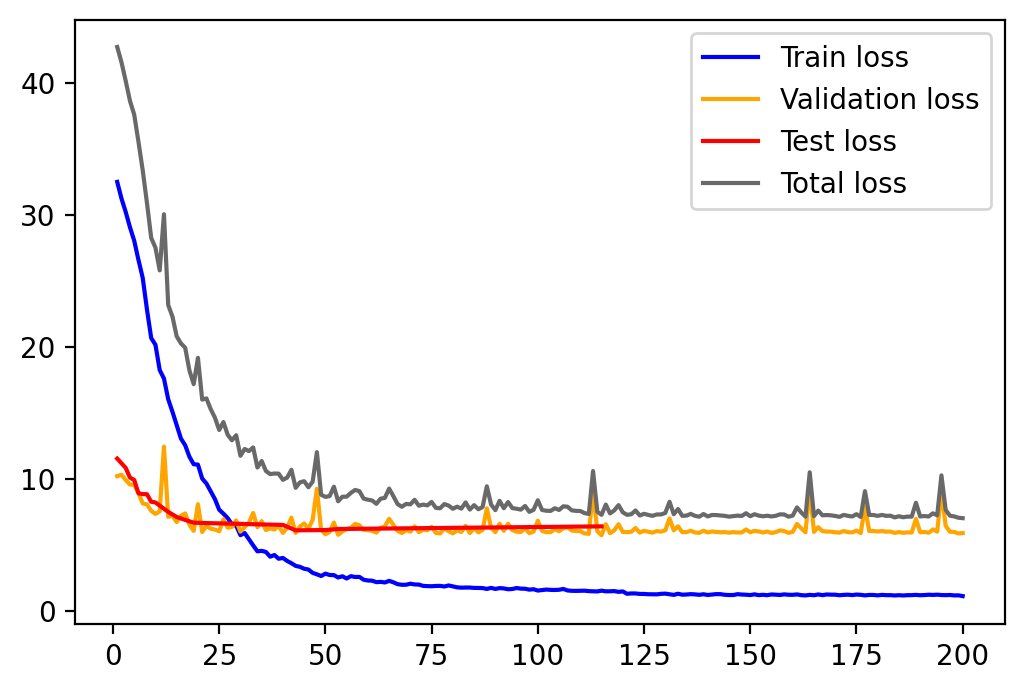

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [25]:
tsloss = 0
model.load_state_dict(torch.load('state_cnn_ts3_2.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


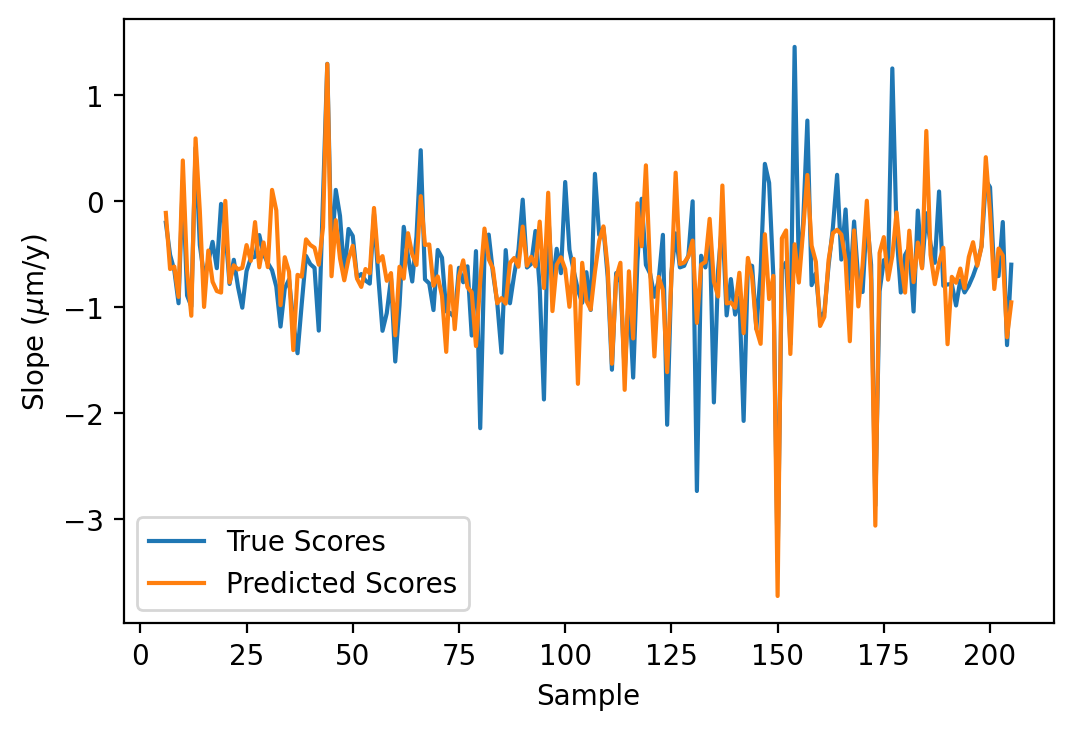

In [26]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

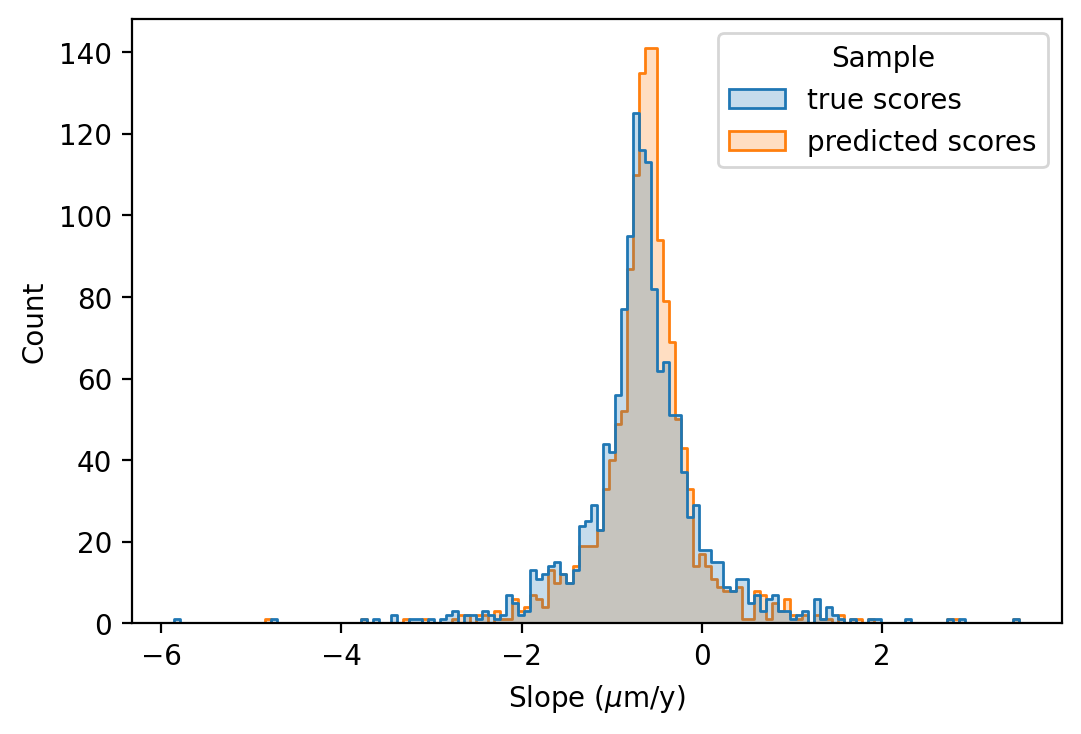

In [27]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [28]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.08906882591093117, pvalue=1.5486356289881706e-05)


In [29]:
df.to_csv('predscores.csv')

In [30]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [31]:
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('predscores.csv')

In [33]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [34]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [35]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [36]:
coefficient_of_dermination

0.43440409065316277

In [37]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [38]:
rsquared(true, pred)

0.4623647597482398

In [39]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6554435360208855, pvalue=1.1725875018713395e-182)

In [40]:
scipy.stats.pearsonr(true, pred)

(0.67997408755646, 1.1087197917211379e-201)